In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
X_train_bow = pickle.load(open("/content/drive/MyDrive/Resume Project/Donors Choose Dataset/X_train_1.pkl",'rb'))
X_test_bow = pickle.load(open("/content/drive/MyDrive/Resume Project/Donors Choose Dataset/X_test_1.pkl",'rb'))
X_train_tf = pickle.load(open("/content/drive/MyDrive/Resume Project/Donors Choose Dataset/X_train_2.pkl",'rb'))
X_test_tf = pickle.load(open("/content/drive/MyDrive/Resume Project/Donors Choose Dataset/X_test_2.pkl",'rb'))
y_train = pickle.load(open("/content/drive/MyDrive/Resume Project/Donors Choose Dataset/y_train.pkl",'rb'))
y_test = pickle.load(open("/content/drive/MyDrive/Resume Project/Donors Choose Dataset/y_test.pkl",'rb'))

#Set 1: categorical(School_State,Teacher_Prefix,CLean_Category,Clean_Subcategory,Project_Grade_Category), numerical features(price,teacher_number of previously posted projects) + preprocessed_essay (BOW)

In [3]:
clf1 = MultinomialNB(class_prior=[0.5,0.5])
parameters = {'alpha':[0.0000001,0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
clf = RandomizedSearchCV(clf1 , param_distributions=parameters,cv=10, scoring = 'roc_auc' , return_train_score=True)
clf = clf.fit(X_train_bow,y_train)
results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

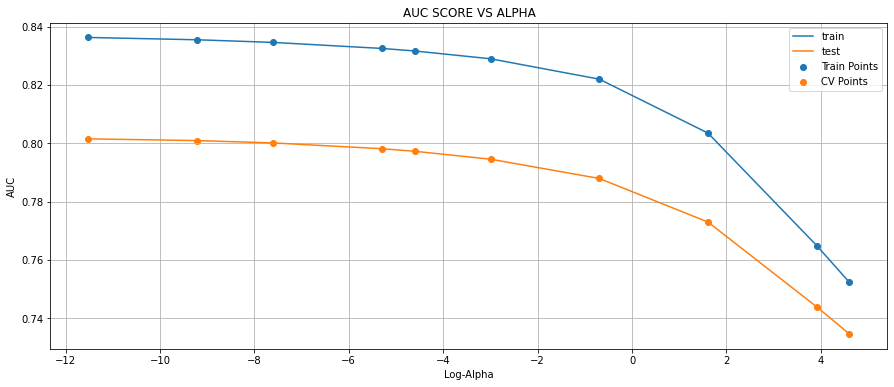

In [4]:
alpha = results['param_alpha'].values
alpha =[math.log(i) for i in alpha]
train_auc=results['mean_train_score'].values
cv_auc=results['mean_test_score'].values
plt.figure(figsize=(15,6))
plt.plot(alpha , train_auc ,label='train')
plt.plot(alpha , cv_auc , label = 'test')
plt.scatter(alpha, train_auc , label='Train Points')
plt.scatter(alpha, cv_auc, label = 'CV Points')
plt.title('AUC SCORE VS ALPHA')
plt.xlabel('Log-Alpha')
plt.ylabel('AUC')
plt.legend()
plt.grid()

In [5]:
print(clf.best_estimator_)
print(clf.best_params_)
alpha_bow=clf.best_params_
clf = clf.best_estimator_

MultinomialNB(alpha=1e-05, class_prior=[0.5, 0.5])
{'alpha': 1e-05}


In [6]:
def batch_predict_probability(classifier, data):
  y_data_pred =[]
  tr_loop = data.shape[0]-data.shape[0]%1000
  for i in tqdm(range(0, tr_loop,1000)):
    y_data_pred.extend(classifier.predict_proba(data[i:i+1000])[:,1])
  if data.shape[0]%1000!=0:
    y_data_pred.extend(classifier.predict_proba(data[tr_loop:])[:,1])
  return y_data_pred


100%|██████████| 16/16 [00:00<00:00, 340.08it/s]


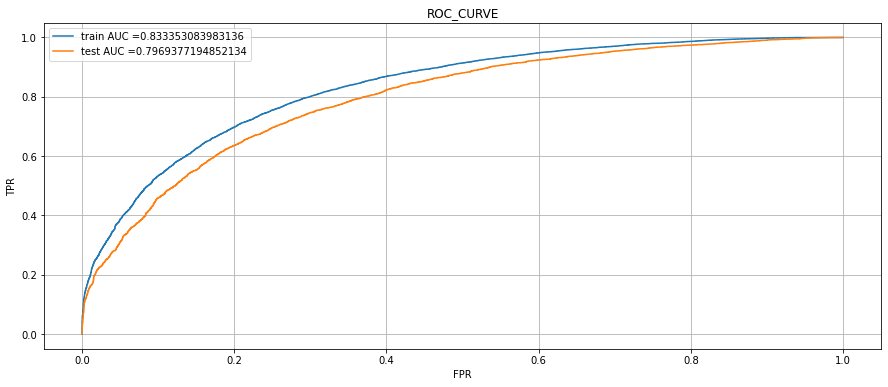

In [7]:
clf.fit(X_train_bow,y_train)
y_train_pred_bow = batch_predict_probability(clf , X_train_bow)
y_test_pred_bow = batch_predict_probability(clf, X_test_bow)
train_fpr_bow , train_tpr_bow , train_thresold_bow = roc_curve(y_train, y_train_pred_bow)
test_fpr_bow , test_tpr_bow , test_thresold_bow =roc_curve(y_test, y_test_pred_bow)
plt.figure(figsize=(15,6))
plt.plot(train_fpr_bow, train_tpr_bow, label="train AUC ="+str(auc(train_fpr_bow, train_tpr_bow)))
plt.plot(test_fpr_bow, test_tpr_bow, label="test AUC ="+str(auc(test_fpr_bow, test_tpr_bow)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC_CURVE")
plt.grid()
plt.show()

In [8]:
def batch_predict(classifier, data):
  y_data_pred =[]
  tr_loop = data.shape[0]-data.shape[0]%1000
  for i in tqdm(range(0, tr_loop,1000)):
    y_data_pred.extend(classifier.predict(data[i:i+1000]))
  if data.shape[0]%1000!=0:
    y_data_pred.extend(classifier.predict(data[tr_loop:]))
  return y_data_pred

In [9]:
clf.fit(X_train_bow,y_train)
y_train_pred_bow = batch_predict(clf ,X_train_bow)
y_test_pred_bow = batch_predict(clf, X_test_bow)
cm_train = confusion_matrix(y_train,batch_predict(clf ,X_train_bow))
cm_test = confusion_matrix(y_test , batch_predict(clf , X_test_bow))
print('*'*10)
print(cm_train)
print('*'*10)
print(cm_test)

100%|██████████| 16/16 [00:00<00:00, 356.28it/s]

**********
[[25025  8804]
 [ 7999 25829]]
**********
[[6064 2393]
 [2291 6167]]


Text(33.0, 0.5, 'True')

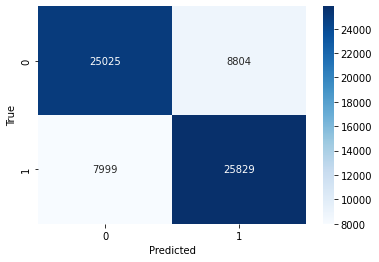

In [10]:
#https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
import seaborn as sns
sns.heatmap(cm_train , annot=True,fmt ='d',cmap="Blues")
ax=plt.subplot()
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

Text(33.0, 0.5, 'True')

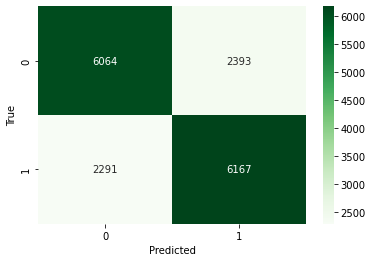

In [11]:
sns.heatmap(cm_test, annot=True,fmt="d",cmap='Greens')
ax=plt.subplot()
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

#Set 2: categorical(School_State,Teacher_Prefix,CLean_Category,Clean_Subcategory,Project_Grade_Category), numerical features(price,teacher_number of previously posted projects) + preprocessed_essay (TF_IDF)

## TF_IDF:essay

In [12]:
clf = MultinomialNB(class_prior=[0.5,0.5])
parameters = {'alpha':[0.0000001,0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
clf = RandomizedSearchCV(clf , param_distributions=parameters,cv=10, scoring = 'roc_auc' , return_train_score=True)
clf = clf.fit(X_train_tf,y_train)
results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])


Text(0.5, 0, 'Log-Alpha')

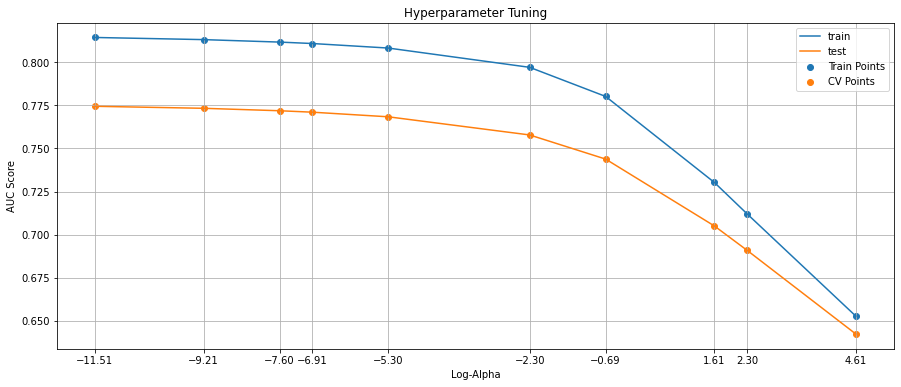

In [13]:
alpha = results['param_alpha'].values
alpha =[math.log(i) for i in alpha]
train_auc=results['mean_train_score'].values
cv_auc=results['mean_test_score'].values
plt.figure(figsize=(15,6))
plt.plot(alpha , train_auc ,label='train')
plt.plot(alpha , cv_auc , label = 'test')
plt.scatter(alpha, train_auc , label='Train Points')
plt.scatter(alpha, cv_auc, label = 'CV Points')
plt.title('Hyperparameter Tuning')
plt.legend()
plt.grid()
plt.xticks(alpha)
plt.ylabel('AUC Score')
plt.xlabel('Log-Alpha')

In [14]:
print(clf.best_estimator_)
print(clf.best_params_)
alpha_tf=clf.best_params_
clf =clf.best_estimator_

MultinomialNB(alpha=1e-05, class_prior=[0.5, 0.5])
{'alpha': 1e-05}


So the maximum AUC is found for alpha =1e-07

100%|██████████| 16/16 [00:00<00:00, 348.27it/s]


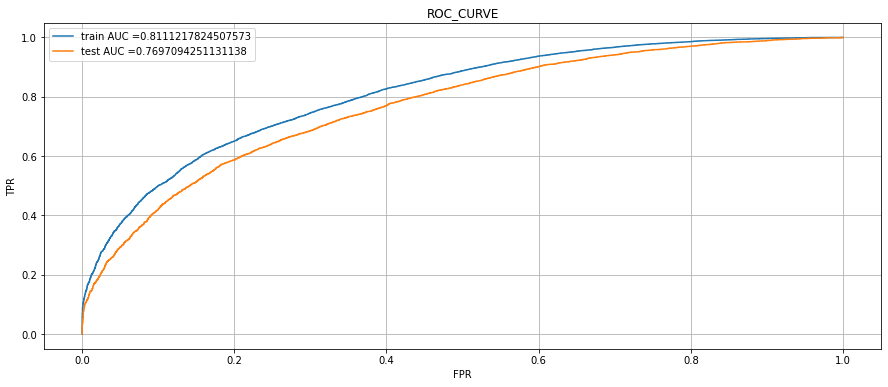

In [15]:
clf.fit(X_train_tf,y_train)
y_train_pred = batch_predict_probability(clf , X_train_tf)
y_test_pred = batch_predict_probability(clf, X_test_tf)
train_fpr_tf, train_tpr_tf , train_thresold_tf = roc_curve(y_train, y_train_pred)
test_fpr_tf , test_tpr_tf , test_thresold_tf =roc_curve(y_test, y_test_pred)
plt.figure(figsize=(15,6))
plt.plot(train_fpr_tf, train_tpr_tf, label="train AUC ="+str(auc(train_fpr_tf, train_tpr_tf)))
plt.plot(test_fpr_tf, test_tpr_tf, label="test AUC ="+str(auc(test_fpr_tf, test_tpr_tf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC_CURVE")
plt.grid()
plt.show()

In [16]:
def batch_predict(classifier, data):
  y_data_pred =[]
  tr_loop = data.shape[0]-data.shape[0]%1000
  for i in tqdm(range(0, tr_loop,1000)):
    y_data_pred.extend(classifier.predict(data[i:i+1000]))
  if data.shape[0]%1000!=0:
    y_data_pred.extend(classifier.predict(data[tr_loop:]))
  return y_data_pred

In [17]:
y_train_pred_tf= batch_predict(clf, X_train_tf)
y_test_pred_tf = batch_predict(clf, X_test_tf)
cm_test = confusion_matrix(y_test , batch_predict(clf , X_test_tf))
cm_train =confusion_matrix(y_train,batch_predict(clf ,X_train_tf))
print('*'*10)
print(cm_train)
print('*'*10)
print(cm_test)

100%|██████████| 67/67 [00:00<00:00, 396.53it/s]


**********
[[23765 10064]
 [ 8708 25120]]
**********
[[5696 2761]
 [2440 6018]]


Text(33.0, 0.5, 'True')

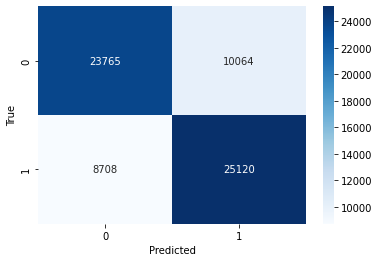

In [18]:
#https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
import seaborn as sns
sns.heatmap(cm_train , annot=True,fmt ='d',cmap="Blues")
ax=plt.subplot()
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

Text(33.0, 0.5, 'True')

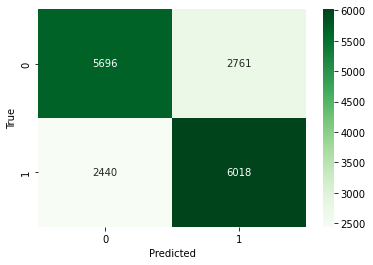

In [19]:
sns.heatmap(cm_test, annot=True,fmt="d",cmap='Greens')
ax=plt.subplot()
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

In [20]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter: Alpha", "Train AUC", "Test AUC"]


x.add_row(["BOW", "Multinomial NB", alpha_bow, round(auc(train_fpr_bow,train_tpr_bow),2),round(auc(test_fpr_bow,test_tpr_bow),2)])
x.add_row(["TF-IDF", "Multinomial NB", alpha_tf, round(auc(train_fpr_tf,train_tpr_tf),2),round(auc(test_fpr_tf,test_tpr_tf),2)])

print(x)

+------------+----------------+-----------------------+-----------+----------+
| Vectorizer |     Model      | Hyperparameter: Alpha | Train AUC | Test AUC |
+------------+----------------+-----------------------+-----------+----------+
|    BOW     | Multinomial NB |    {'alpha': 1e-05}   |    0.83   |   0.8    |
|   TF-IDF   | Multinomial NB |    {'alpha': 1e-05}   |    0.81   |   0.77   |
+------------+----------------+-----------------------+-----------+----------+
